In [1]:
import warnings
import awkward as ak
import hist as hs
from hist.intervals import ratio_uncertainty
import numpy as np

from coffea import processor
from coffea.nanoevents.methods import vector, candidate
from numba import jit

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import date
today = date.today()

plt.style.use(hep.style.CMS)
#plt.style.use('dark_background')

In [2]:
class LLP_ntuple_processor(processor.ProcessorABC):
    
    def delta_cls_gLLP(self, events):
        clusts = ak.zip(
            {
                'pt': ak.zeros_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'E': ak.zeros_like(events.cscRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        gLLPs = ak.zip(
            {
                'pt': events.gLLP_pt,
                'phi': events.gLLP_phi,
                'eta': events.gLLP_eta,
                'E': events.gLLP_e,
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )        
        cls_llp_pairs = ak.cartesian({
            "cls": clusts, 
            "llp": gLLPs
        }, nested = True) 
        
        deltaR = (cls_llp_pairs.cls).delta_r(cls_llp_pairs.llp)
        deltaEta = abs(cls_llp_pairs.cls.eta - cls_llp_pairs.llp.eta)
        deltaPhi = np.arctan2(np.sin(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi), 
                              np.cos(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi))
        
        deltaR, deltaEta, deltaPhi = ak.flatten(deltaR, axis=2), ak.flatten(deltaEta, axis=2), ak.flatten(deltaPhi, axis=2)
        return deltaR, deltaEta, deltaPhi,
    
    def delta_cls_leadmuon(self, events):
        clusts = ak.zip(
            {
                'pt': ak.zeros_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'E': ak.zeros_like(events.cscRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        leadMuons = ak.zip(
            {
                'pt': events.leadMuonPt,
                'phi': events.leadMuonPhi,
                'eta': events.leadMuonEta,
                'E': events.leadMuonE,
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          ) 
        cls_muon_pairs = ak.cartesian({
            "cls": clusts, 
            "muon": leadMuons
        }, nested = True)
 
        deltaR = (cls_muon_pairs.cls).delta_r(cls_muon_pairs.muon)
        deltaEta = abs(cls_muon_pairs.cls.eta - cls_muon_pairs.muon.eta)
        deltaPhi = np.arctan2(np.sin(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi), 
                              np.cos(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi))
        
        deltaR, deltaEta, deltaPhi = ak.flatten(deltaR, axis=2), ak.flatten(deltaEta, axis=2), ak.flatten(deltaPhi, axis=2)
        return deltaR, deltaEta, deltaPhi
        
    
    def process(self, events):
        
        signame = 'Phi'
        
        # >>> output dict init >>>
        dataset = events.metadata['dataset']
        out = {
            dataset: {},
            f'{dataset}_cuts': {},
            f'{dataset}_vars': {},
        }
        # <<< output dict init <<<
        
        out[dataset][f'numEvents_pretrigger'] = len(events)
        
        # >>> some preprocessing >>>
        
            # add a new set of branches that only consists of values pertaining to muons
        muoncut = abs(events.lepPdgId) == 13
        events['muonE'] = events.lepE[muoncut]
        events['muonPt'] = events.lepPt[muoncut]
        events['muonEta'] = events.lepEta[muoncut]
        events['muonPhi'] = events.lepPhi[muoncut]
        events['muonPdgId'] = events.lepPdgId[muoncut]
        events['muonDZ'] = events.lepDZ[muoncut]
        events['muonLooseId'] = events.lepLooseId[muoncut]
        events['muonTightId'] = events.lepTightId[muoncut] 
        if 'mPhi0p3' in dataset:
            events['muonType'] = events.lepMuonType[muoncut]
            events['muonQuality'] = events.lepMuonQuality[muoncut]
            events['muon_passHLTFilter'] = events.lepMuon_passHLTFilter[muoncut]
        events = events[ak.count(events.muonPt, axis=1) > 0] #kill all events with empty muons
        out[dataset][f'numEvents_|muonId| == 13'] = len(events.muonPt)
        
        
            # cut and mutate events based on this new branch
        def muoncutter(events, muoncut):
            events['muonE'] = events.muonE[muoncut]
            events['muonPt'] = events.muonPt[muoncut]
            events['muonEta'] = events.muonEta[muoncut]
            events['muonPhi'] = events.muonPhi[muoncut]
            events['muonPdgId'] = events.muonPdgId[muoncut]
            events['muonDZ'] = events.muonDZ[muoncut]
            events['muonLooseId'] = events.muonLooseId[muoncut]
            events['muonTightId'] = events.muonTightId[muoncut]
            if 'mPhi0p3' in dataset:
                events['muonType'] = events.muonType[muoncut]
                events['muonQuality'] = events.muonQuality[muoncut]
                events['muon_passHLTFilter'] = events.muon_passHLTFilter[muoncut]
            events = events[ak.count(events.muonPt, axis=1) > 0] #kill all events with empty muons
            return events

        if 'mPhi0p3' in dataset:
            events = muoncutter(events, ak.any(events.muon_passHLTFilter[:,:,range(60,68)], axis=2))
            out[dataset][f'numEvents_muonHLTReq'] = len(events.muonPt)
            
        events = muoncutter(events, abs(events.muonEta) < 1.5)
        out[dataset][f'numEvents_|muonEta| < 1.5'] = len(events.muonPt)
        events = muoncutter(events, events.muonPt > 7)
        out[dataset][f'numEvents_muonPt > 7'] = len(events.muonPt)
        
        if 'mPhi0p3' in dataset:       
            events = muoncutter(events, events.muonQuality >= 2**25)
            out[dataset][f'numEvents_soft_muon_ID'] = len(events.muonPt) 
            
            # finally keep only the leading muon
        leadcut = (ak.max(events.muonPt, axis=1, mask_identity=True) == events.muonPt)
        events['leadMuonE'] = events.muonE[leadcut][:,0]
        events['leadMuonPt'] = events.muonPt[leadcut][:,0]
        events['leadMuonEta'] = events.muonEta[leadcut][:,0]
        events['leadMuonPhi'] = events.muonPhi[leadcut][:,0]
        events['leadMuonPdgId'] = events.muonPdgId[leadcut][:,0]
        events['leadMuonDZ'] = events.muonDZ[leadcut][:,0]
        events['leadMuonLooseId'] = events.muonLooseId[leadcut][:,0]
        events['leadMuonTightId'] = events.muonTightId[leadcut][:,0]
        if 'mPhi0p3' in dataset:
            events['leadMuonType'] = events.muonType[leadcut][:,0]
            events['leadMuonQuality'] = events.muonQuality[leadcut][:,0]
            events['leadMuon_passHLTFilter'] = events.muon_passHLTFilter[leadcut][:,0]                
        out[dataset][f'numEvents_leadMuon_cut'] = len(events.leadMuonPt)

            # add branches pertaining to deltaR between either leading muon and cluster, or llp and cluster
        if signame in dataset:
            cls_llp_deltaR, cls_llp_deltaEta, cls_llp_deltaPhi = self.delta_cls_gLLP(events)
            events['cscRechitCluster_llp_deltaR'] = cls_llp_deltaR
            events['cscRechitCluster_llp_deltaEta'] = cls_llp_deltaEta
            events['cscRechitCluster_llp_deltaPhi'] = cls_llp_deltaPhi

            events['gLLP_decay_vertex_z_matched'] = events.gLLP_decay_vertex_z.mask[ak.any(cls_llp_deltaR < .4, axis=1)]
            events['gLLP_e_matched'] = events.gLLP_e.mask[ak.any(cls_llp_deltaR < .4, axis=1)]
            
        cls_leadmuon_deltaR, cls_leadmuon_deltaEta, cls_leadmuon_deltaPhi = self.delta_cls_leadmuon(events)
        events['cscRechitCluster_leadmuon_deltaR'] = cls_leadmuon_deltaR
        events['cscRechitCluster_leadmuon_deltaEta'] = cls_leadmuon_deltaEta
        events['cscRechitCluster_leadmuon_deltaPhi'] = cls_leadmuon_deltaPhi
        # <<< some preprocessing <<<

        
        # >>> cut definitions >>> 
        dummy = ak.values_astype(ak.ones_like(events.nCscRechitClusters), 'bool') #dummy truth vector of same shape as csc variables
        cscCuts = {
            'posttrigger': dummy, 
            'llp_acc': (events.gLLP_csc == 1) if signame in dataset else dummy,
            'num Cluster > 0': (events.nCscRechitClusters > 0),
            'dR_gllp_cls < .4': (events.cscRechitCluster_llp_deltaR < .4) if signame in dataset else dummy,
            'dR_lmuon_cls > .8': (events.cscRechitCluster_leadmuon_deltaR > .8),
            'ME1112_veto': ((events.cscRechitClusterNRechitChamberPlus11 <= 0)&(events.cscRechitClusterNRechitChamberMinus11 <= 0)&
                            (events.cscRechitClusterNRechitChamberPlus12 <= 0)&(events.cscRechitClusterNRechitChamberMinus12 <= 0)),
            're12_veto': (events.cscRechitCluster_match_RE12_0p4 == 0),
            'mb1_veto': (events.cscRechitCluster_match_MB1Seg_0p4 == 0),
            'rb1_veto': (events.cscRechitCluster_match_RB1_0p4 == 0),
            'muon_veto_pt < 20': (events.cscRechitClusterMuonVetoPt < 20),
            '-5 < cls_time < 12.5': ((events.cscRechitClusterTimeWeighted <= 12.5)&(events.cscRechitClusterTimeWeighted >= -5)),
            '|cls_timeSpread| < 20': (events.cscRechitClusterTimeSpreadWeightedAll <= 20),
            '|cls_eta| < 1.9': (abs(events.cscRechitClusterEta) < 1.9),
            'cut_based_ID': (((events.cscRechitClusterNStation10 >  1) & (abs(events.cscRechitClusterEta) < 1.9)) |
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 4) & (abs(events.cscRechitClusterEta) < 1.8)) |
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 3) & (abs(events.cscRechitClusterEta) < 1.6)) |
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 2) & (abs(events.cscRechitClusterEta) < 1.6)) |
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 1) & (abs(events.cscRechitClusterEta) < 1.1))),
            'cls_size > 130': (events.cscRechitClusterSize >= 130),
        }
        # <<< cut definitions <<<

        # >>> variables to be plotted >>>                
        __ = lambda x: x
        bins = 30
        
        #must be same shape as any csc variable
        cscVars = {
            'cscRechitClusterNRechitChamberPlus11':  [bins,    0,  10, __, ],
            'cscRechitClusterNRechitChamberMinus11': [bins,    0,  10, __, ],
            'cscRechitClusterNRechitChamberPlus12':  [bins,    0,  10, __, ],
            'cscRechitClusterNRechitChamberMinus12': [bins,    0,  10, __, ],
            'cscRechitCluster_match_RE12_0p4':       [bins,    0,  10, __, ],
            'cscRechitCluster_match_MB1Seg_0p4':     [bins,    0,  10, __, ],
            'cscRechitCluster_match_RB1_0p4':        [bins,    0,  10, __, ],
            'cscRechitClusterMuonVetoPt':            [bins,    0, 100, __, ],
            'cscRechitClusterTimeWeighted':          [bins,  -20,  20, __, ],
            'cscRechitClusterTimeSpreadWeightedAll': [bins,    0,  30, __, ],
            'cscRechitClusterEta':                   [bins,    0,   3, abs,],
            'cscRechitClusterSize':                  [bins,    50, 300, __, ],
            'cscRechitClusterNStation10':            [bins,    0,   5, __, ],
            'cscRechitClusterAvgStation10':          [bins,    0,   5, abs, ],
        }
        
        if 'background' in dataset: # this is explicitly to protect from unblinding data
            cscVars['cscRechitClusterSize'] = [int(bins/5),    50, 100, __, ]

        if signame in dataset:
            cscVars['cscRechitCluster_llp_deltaR']   = [bins, 0, 5, __,]
            cscVars['cscRechitCluster_llp_deltaEta'] = [bins, 0, 5, abs,]
            cscVars['cscRechitCluster_llp_deltaPhi'] = [bins, 0, 5, __,]

        cscVars['cscRechitCluster_leadmuon_deltaR']   = [bins, 0, 5, __,]
        cscVars['cscRechitCluster_leadmuon_deltaEta'] = [bins, 0, 5, abs,]
        cscVars['cscRechitCluster_leadmuon_deltaPhi'] = [bins, 0, 5, __,]
        
        #must be flat variables of length nEvents
        eventVars = {
            'metEENoise': [bins,   0, 100, __, ],
            'gLLP_ctau': [bins, 0, 1e3, __, ],
        }
        
        if signame in dataset:        
            eventVars['gLLP_decay_vertex_z'] = [2*bins,   0, 1200, abs, ]
            eventVars['gLLP_decay_vertex_z_matched'] = [2*bins,   0, 1200, abs, ]
            eventVars['gLLP_e'] = [bins,   0, 100, __, ]
            eventVars['gLLP_e_matched'] = [bins,   0, 100, __, ]
            
        Vars = cscVars | eventVars
        # <<< variables to be plotted <<<
        
        
        # >>> create hists >>> 
        bigCut = cscCuts[list(cscCuts.keys())[0]] #sets first cut
        for cut in cscCuts:
            out[f'{dataset}_cuts'][cut] = 1       
            bigCut = bigCut & cscCuts[cut]
            
            if bigCut.layout.minmax_depth == (2,2):
                temp = ak.any(bigCut, axis=1)
            elif bigCut.layout.minmax_depth == (1,1):
                temp = bigCut
                          
            out[dataset][f'numEvents_{cut}'] = sum(temp)
            
            for var in Vars:

                out[f'{dataset}_vars'][var] = 1  
                v = Vars[var]
                
                if bigCut.layout.minmax_depth == (2,2) and events[var].layout.minmax_depth == (1,1):
                    temp2 = ak.any(bigCut, axis=1)
                else:
                    temp2 = bigCut
                
                data = ak.flatten(events[var][temp2], axis=None)
                data = v[3](data)
                key = f'{var} with {cut}'
                out[f'{dataset}_vars'][key] = data.to_list()
                if 'gLLP_e' in var:
                    out[dataset][key] = hs.Hist.new.Reg(v[0], v[1]+1, v[2], name=var, label=var, transform=hs.axis.transform.log).Double()
                else:
                    out[dataset][key] = hs.Hist.new.Reg(v[0], v[1], v[2], name=var, label=var).Double()
                out[dataset][key].fill(data) 
        # <<< create hists <<<
        return out
    
    def postprocess(self, accumulator):
        return accumulator
    

In [3]:
# prefix = 'rootfiles/'
# fileset = {
#             'PhiToPi0Pi0_mPhi1p0_ctau1000':
#                 [prefix + 'BToKPhi_MuonGenFilter_mPhi1p0_ctau1000_1pb_weighted.root'],
    
#             'PhiToPi0Pi0_mPhi0p3_ctau1000':
#                 [prefix + 'BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau1000_1pb_weighted.root'],

#             'PhiToPi0Pi0_mPhi0p3_ctau300':
#                 [prefix + 'BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_1pb_weighted.root'],

#             'PhiToPiPlusPiMinus_mPhi0p3_ctau300':
#                 [prefix + 'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau300_1pb_weighted.root'],

#             'PhiToPiPlusPiMinus_mPhi0p3_ctau1000':
#                 [prefix + 'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau1000_1pb_weighted.root'],
#             }
# #fileset['backgroundNew'] = [prefix + 'ParkingBPH4_2018A_goodLumi.root']

prefix = 'root://cmsxrootd.fnal.gov//store/user/christiw/displacedJetMuonAnalyzer/bparking/V1p19/MC_Fall18/v1/v5/normalized/'
fileset = {
            'PhiToPi0Pi0_mPhi0p3_ctau1000':
                [prefix + 'BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau1000_1pb_weighted.root'],

             'PhiToPi0Pi0_mPhi0p3_ctau300':
                 [prefix + '/BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_1pb_weighted.root'],

            'PhiToPiPlusPiMinus_mPhi0p3_ctau300':
                [prefix + 'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau300_1pb_weighted.root'],

            'PhiToPiPlusPiMinus_mPhi0p3_ctau1000':
                [prefix + 'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau1000_1pb_weighted.root'],
            }
fileset['PhiToPi0Pi0_mPhi1p0_ctau1000'] = ['root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/v3/normalized/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000_1pb_weighted.root',]
#fileset['backgroundNew'] = ['root://cmsxrootd.fnal.gov//store/user/christiw/displacedJetMuonAnalyzer/bparking/V1p19/Data2018_UL/v6/normalized/ParkingBPH4_2018A_goodLumi.root']


out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 10},
    # executor_args={"schema": BaseSchema, "workers": 1},
    #maxchunks = 1,
    # chunksize=100000000,
)

Output()

Output()

In [4]:
datasets = list(fileset.keys())
sigcuts = list(out[f'{list(fileset.keys())[0]}_cuts'].keys())
# bkguts = list(out['backgroundNew_cuts'].keys())

sigvars = list(out[f'{list(fileset.keys())[0]}_vars'].keys())
# bkgvars = list(out['backgroundNew_vars'].keys())

In [5]:
signame = "Phi"
for dataset in datasets:
    print(dataset)
    if signame in dataset:
        if 'ctau1000' in dataset:
            oldctau = 100
        if 'ctau300' in dataset:
            oldctau = 30

        N_events_acceptance = out[dataset]["numEvents_llp_acc"]
        N_events_no_cut = out[dataset]["numEvents_posttrigger"]

        # _________________ Efficiency calculation _________________
        eff_sig_old = N_events_acceptance / N_events_no_cut

        def weight_calc(llp_ct, new_ctau, old_ctau):
            return (old_ctau/new_ctau) * np.exp(llp_ct*(1/old_ctau - 1/new_ctau))

        ctau_list = np.logspace(-.3, 4, 50)
        eff = np.zeros_like(ctau_list)
        gLLP_ctau = np.array(out[f"{dataset}_vars"]["gLLP_ctau with llp_acc"]) #cuts gLLP_ctau

        for i, ct in enumerate(ctau_list):
            weight_ctau = weight_calc(gLLP_ctau, ct, oldctau) # convert everything to cm
            eff_sig_new = np.sum(weight_ctau)/out[dataset]["numEvents_posttrigger"]
            eff[i] = eff_sig_new

        out[dataset]['ctau_list'] = ctau_list
        out[dataset]['eff'] = eff

        # _________________ Branching ratio estimation _________________
        cutevents = out[dataset]["numEvents_posttrigger"]
        n_events_inverse = 1/cutevents
        print(N_events_acceptance*n_events_inverse)

        def weight_calc(llp_ct, new_ctau, old_ctau):
            return (old_ctau/new_ctau) * np.exp(llp_ct*(1/old_ctau - 1/new_ctau))

        br = np.zeros_like(ctau_list)

        gLLP_ctau = np.array(out[f"{dataset}_vars"]["gLLP_ctau with cls_size > 130"]) #cuts gLLP_ctau

        nb = 55
        frac_of_B = .02
        BR_old = 2*np.sqrt(nb/frac_of_B)/(5e9*N_events_acceptance*n_events_inverse)

        for i, ct in enumerate(ctau_list):
            weight_ctau = weight_calc(gLLP_ctau, ct, oldctau) # convert everything to cm
            BR_new = 2*np.sqrt(nb/frac_of_B)/(5e9*sum(weight_ctau)*n_events_inverse)
            br[i] = BR_new

        out[dataset]['br'] = br
        # <<< eff and br calculation <<<

PhiToPi0Pi0_mPhi0p3_ctau1000
0.08315355698802496
PhiToPi0Pi0_mPhi0p3_ctau300
0.1129653639562882
PhiToPiPlusPiMinus_mPhi0p3_ctau300
0.11208923123093083
PhiToPiPlusPiMinus_mPhi0p3_ctau1000
0.08456472225027209
PhiToPi0Pi0_mPhi1p0_ctau1000
0.11974763406940063


In [18]:
for junk in out:
    if '_cuts' not in junk and '_vars' not in junk:
        print(junk)
        print([list(out[dataset]['ctau_list']), list(out[junk]['eff'])])

PhiToPi0Pi0_mPhi1p0_ctau1000
[[0.5011872336272722, 0.6134160033222739, 0.7507756939629209, 0.9188937680019572, 1.1246578221198198, 1.3764977638335685, 1.6847311747385425, 2.0619860095022204, 2.523717948083162, 3.0888435964774805, 3.780515477471076, 4.6270705618430465, 5.663191200210693, 6.931326017507085, 8.48342898244072, 10.383087899535756, 12.708129525529293, 15.553808038632717, 19.03670748843424, 23.29951810515372, 28.516882147934723, 34.90254878959579, 42.7181311649226, 52.28382434830956, 63.99152336349263, 78.32087865456269, 95.85894679172917, 117.3242414777768, 143.59617019622158, 175.7510624854793, 215.1062658744057, 263.27411603701364, 322.2279922591419, 394.3831644306426, 482.6957437677871, 590.7837911587943, 723.0755447967351, 884.9908398088808, 1083.163152428003, 1325.7113655901096, 1622.5723898705216, 1985.9082668407484, 2430.604433384409, 2974.879560266062, 3641.031949310677, 4456.353068194609, 5454.245649277327, 6675.592159647419, 8170.4297069661025, 10000.0], [1.3583907

In [19]:
import pickle
filename = 'sampleoutfile.pickle'
outfile = open(filename, 'wb')
pickle.dump(out, outfile)
outfile.close()

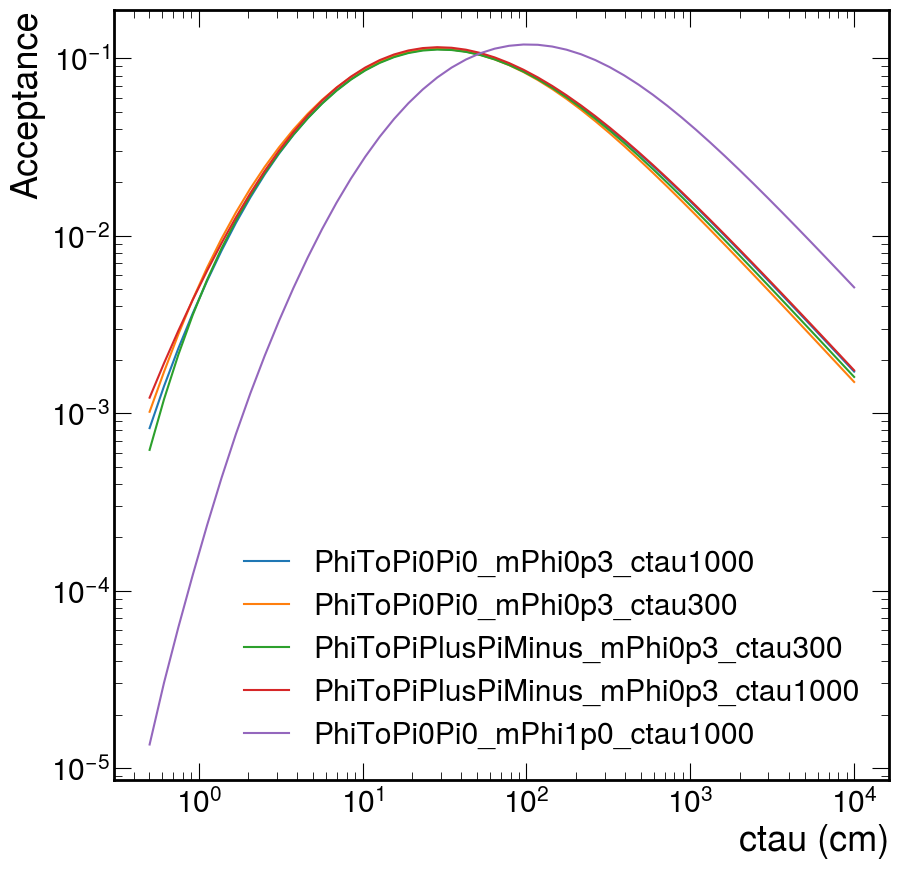

In [25]:
for sets in datasets:
    plt.plot(out[sets]['ctau_list'], out[sets]['eff'], label = sets)
    
plt.xscale("log")
plt.yscale("log")
plt.xlabel("ctau (cm)")
plt.ylabel("Acceptance")
plt.legend()
plt.show()

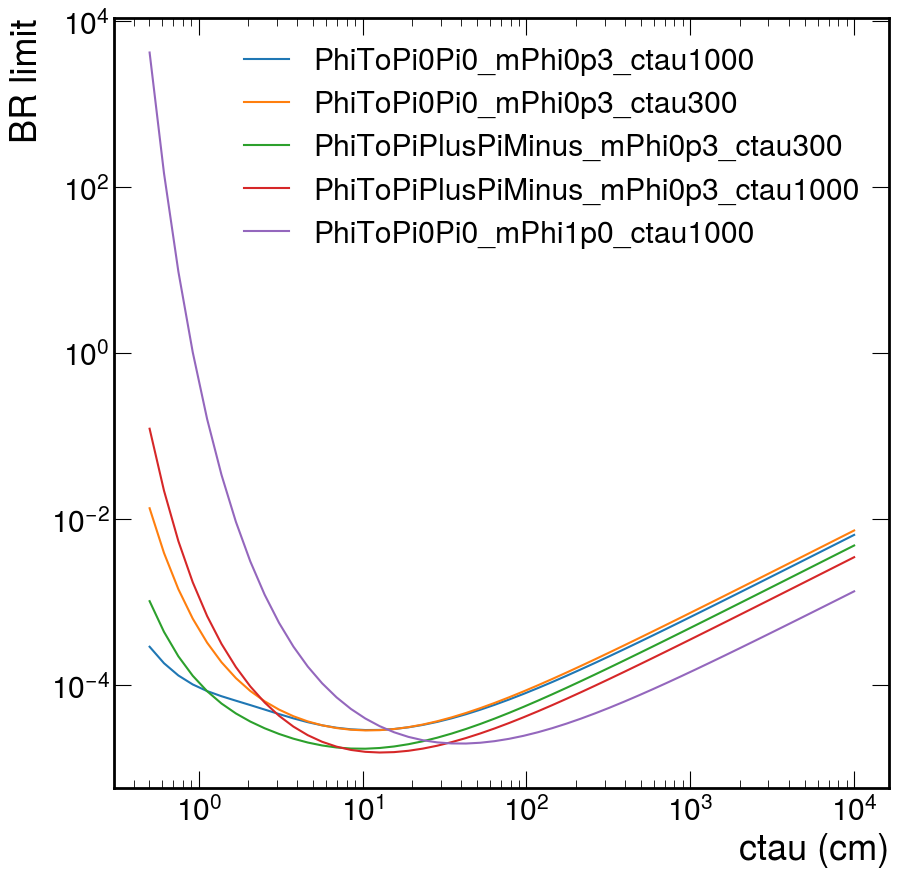

In [26]:
for sets in datasets:
    plt.plot(out[sets]['ctau_list'], out[sets]['br'], label = sets)
    
plt.xscale("log")
plt.yscale("log")
plt.xlabel("ctau (cm)")
plt.ylabel("BR limit")
plt.legend()
plt.show()

In [11]:
datasets = list(fileset.keys())

for dataset in datasets:
    print(dataset)
    for key in out[dataset]:
        if key.startswith('numEvents_'):# and ('NStation10' not in key):
            print(f"{key[10:]}, {out[dataset][key]}")
            #print(f"{out[dataset][key]}")
    print()

PhiToPi0Pi0_mPhi0p3_ctau1000
pretrigger, 927214
|muonId| == 13, 914144
muonHLTReq, 82739
|muonEta| < 1.5, 79621
muonPt > 7, 78978
soft_muon_ID, 77411
posttrigger, 77411
llp_acc, 6437
num Cluster > 0, 741
dR_gllp_cls < .4, 464
dR_lmuon_cls > .8, 441
ME1112_veto, 280
re12_veto, 277
mb1_veto, 276
rb1_veto, 270
muon_veto_pt < 20, 269
-5 < cls_time < 12.5, 268
|cls_timeSpread| < 20, 265
|cls_eta| < 1.9, 160
cut_based_ID, 126
cls_size > 130, 20

PhiToPi0Pi0_mPhi0p3_ctau300
pretrigger, 653247
|muonId| == 13, 644069
muonHLTReq, 57730
|muonEta| < 1.5, 55564
muonPt > 7, 55087
soft_muon_ID, 53990
posttrigger, 53990
llp_acc, 6099
num Cluster > 0, 775
dR_gllp_cls < .4, 565
dR_lmuon_cls > .8, 529
ME1112_veto, 287
re12_veto, 285
mb1_veto, 282
rb1_veto, 280
muon_veto_pt < 20, 276
-5 < cls_time < 12.5, 273
|cls_timeSpread| < 20, 267
|cls_eta| < 1.9, 154
cut_based_ID, 120
cls_size > 130, 30

PhiToPiPlusPiMinus_mPhi0p3_ctau300
pretrigger, 479922
|muonId| == 13, 473137
muonHLTReq, 42883
|muonEta| < 1.5, 4

In [6]:
import mplhep
from hist.intervals import ratio_uncertainty
import matplotlib.patches as patches

plt.style.use(mplhep.style.CMS)


def ratio(num, den, rax):

    rax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view(), "efficiency"),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return rax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(400,1075)
    (xmin,xmax) = ax.get_xlim()
    f = 16
    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=f)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=f)
    ax.text(800, y_max*1.02, 'ME2', fontsize=f)
    ax.text(920, y_max*1.02, 'ME3', fontsize=f)
    ax.text(1015, y_max*1.02,'ME4', fontsize=f)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax


In [13]:
out[key]['gLLP_decay_vertex_z_matched with no_cut'].sum()/out[key]['gLLP_decay_vertex_z with no_cut'].sum()

0.08146477378267215

/tmp/ipykernel_10335/458755856.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_10335/458755856.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_10335/458755856.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_10335/458755856.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


φ→π0π0; ctau = 1000mm; m = 0.3GeV; 
 0.07208326860338667
φ→π0π0; ctau = 300mm; m = 0.3GeV; 
 0.0926381373995737
φ→π+π-; ctau = 300mm; m = 0.3GeV; 
 0.1323070058009817
φ→π+π-; ctau = 1000mm; m = 0.3GeV; 
 0.08146477378267215


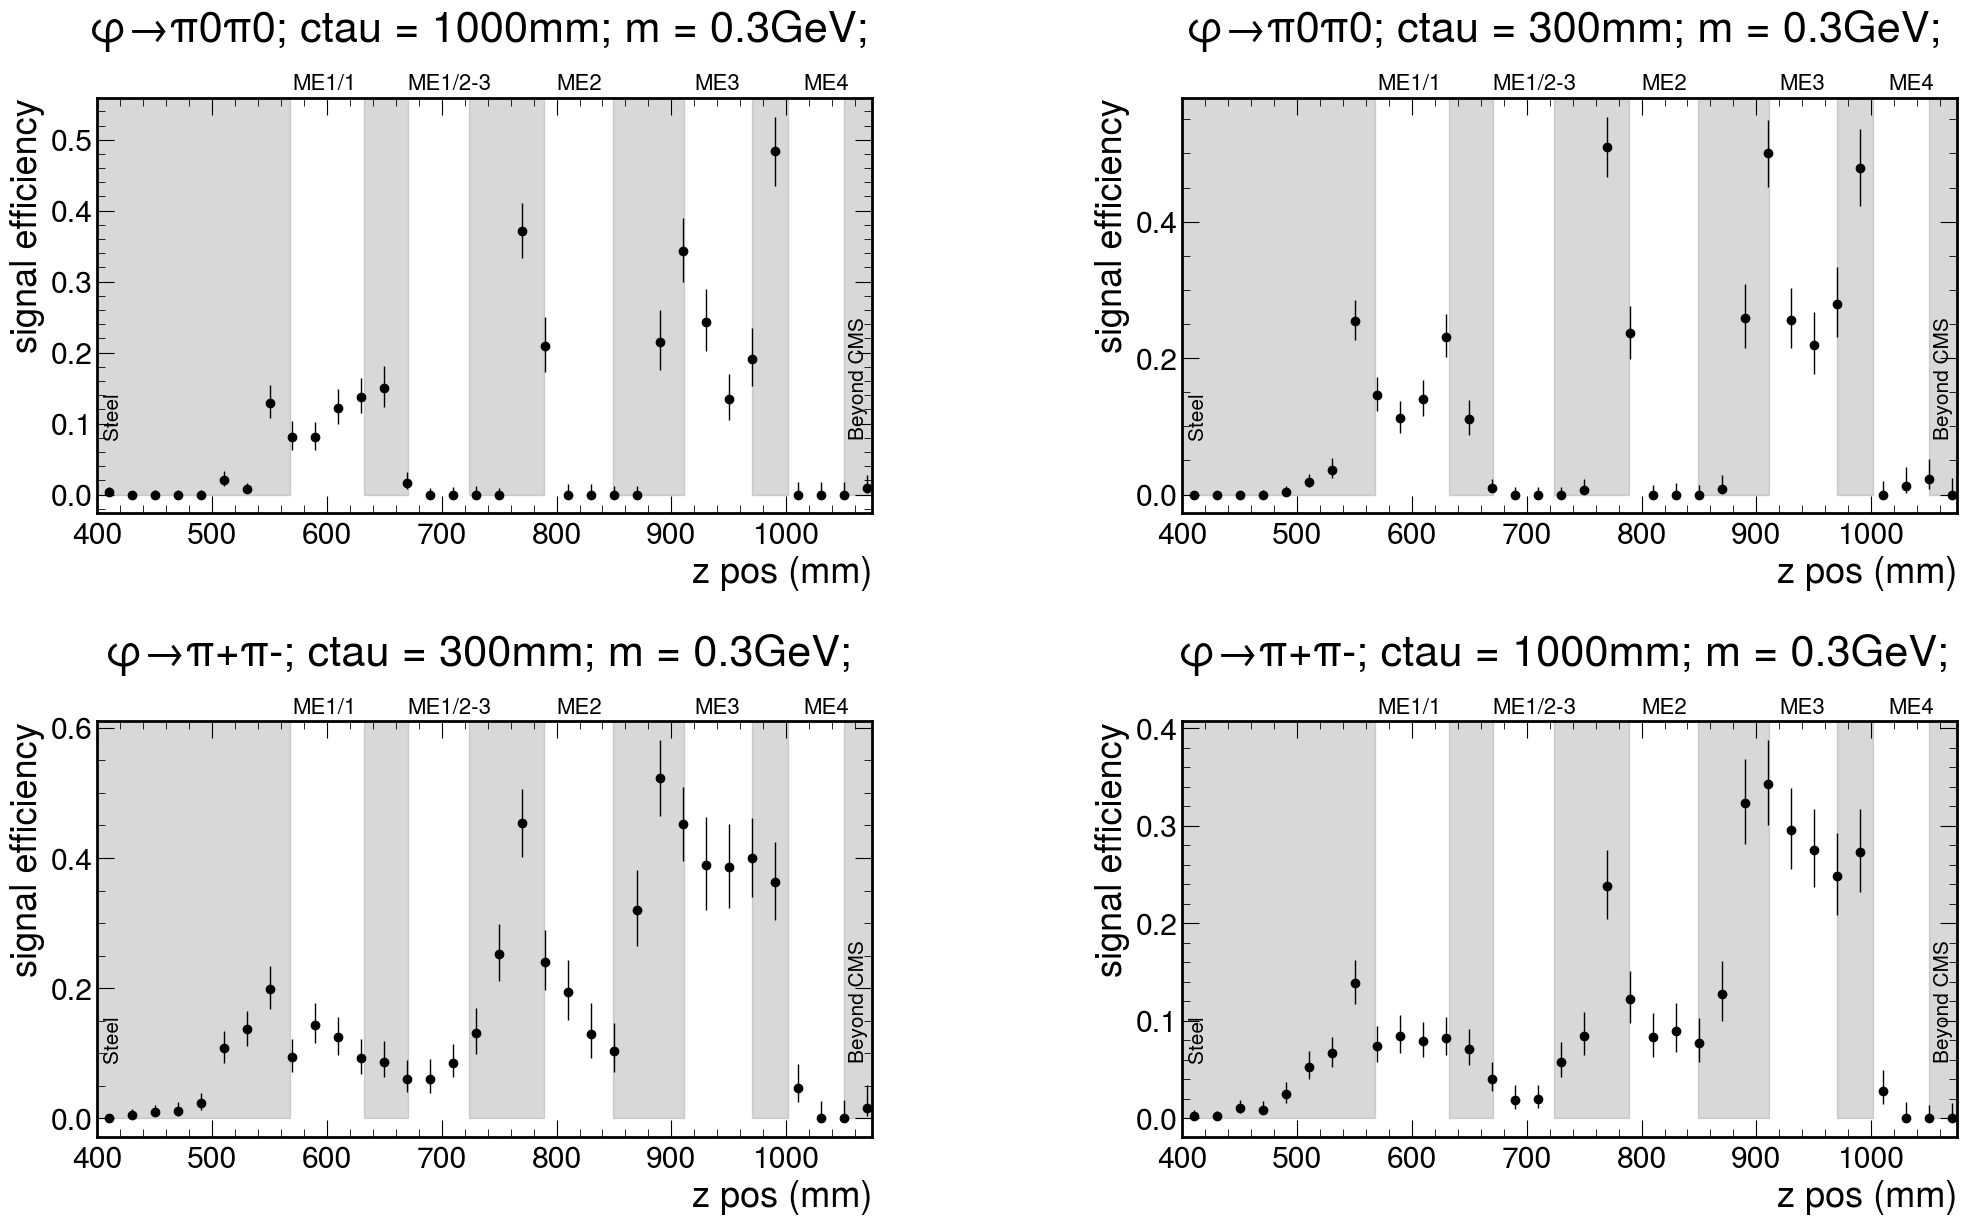

In [15]:
a = 1.5
fig, axes = plt.subplots(2,2, figsize = (a*16,a*9))

for ax, key in zip(axes.flatten(), datasets):
    ratio(out[key]['gLLP_decay_vertex_z_matched with no_cut'], out[key]['gLLP_decay_vertex_z with no_cut'], ax)
    drawCSCz(ax)
    ax.set_xlabel("z pos (mm)")
    ax.set_ylabel("signal efficiency")
    s = ''
    if 'PiPlusPiMinus' in key:
        s+='φ→π+π-; '
    if 'Pi0Pi0' in key:
        s+='φ→π0π0; '

    if 'ctau1000' in key:
        s+='ctau = 1000mm; '
    if 'ctau300' in key:
        s+='ctau = 300mm; '
        
    if '0p3' in key:
        s+='m = 0.3GeV; \n'
    if '1p0' in key:
        s+='m = 1.0GeV; \n'
        
    ax.set_title(s)
    
    print(s, out[key]['gLLP_decay_vertex_z_matched with no_cut'].sum()/out[key]['gLLP_decay_vertex_z with no_cut'].sum())
        
fig.subplots_adjust(hspace=.5, wspace=.4)
        
plt.show()

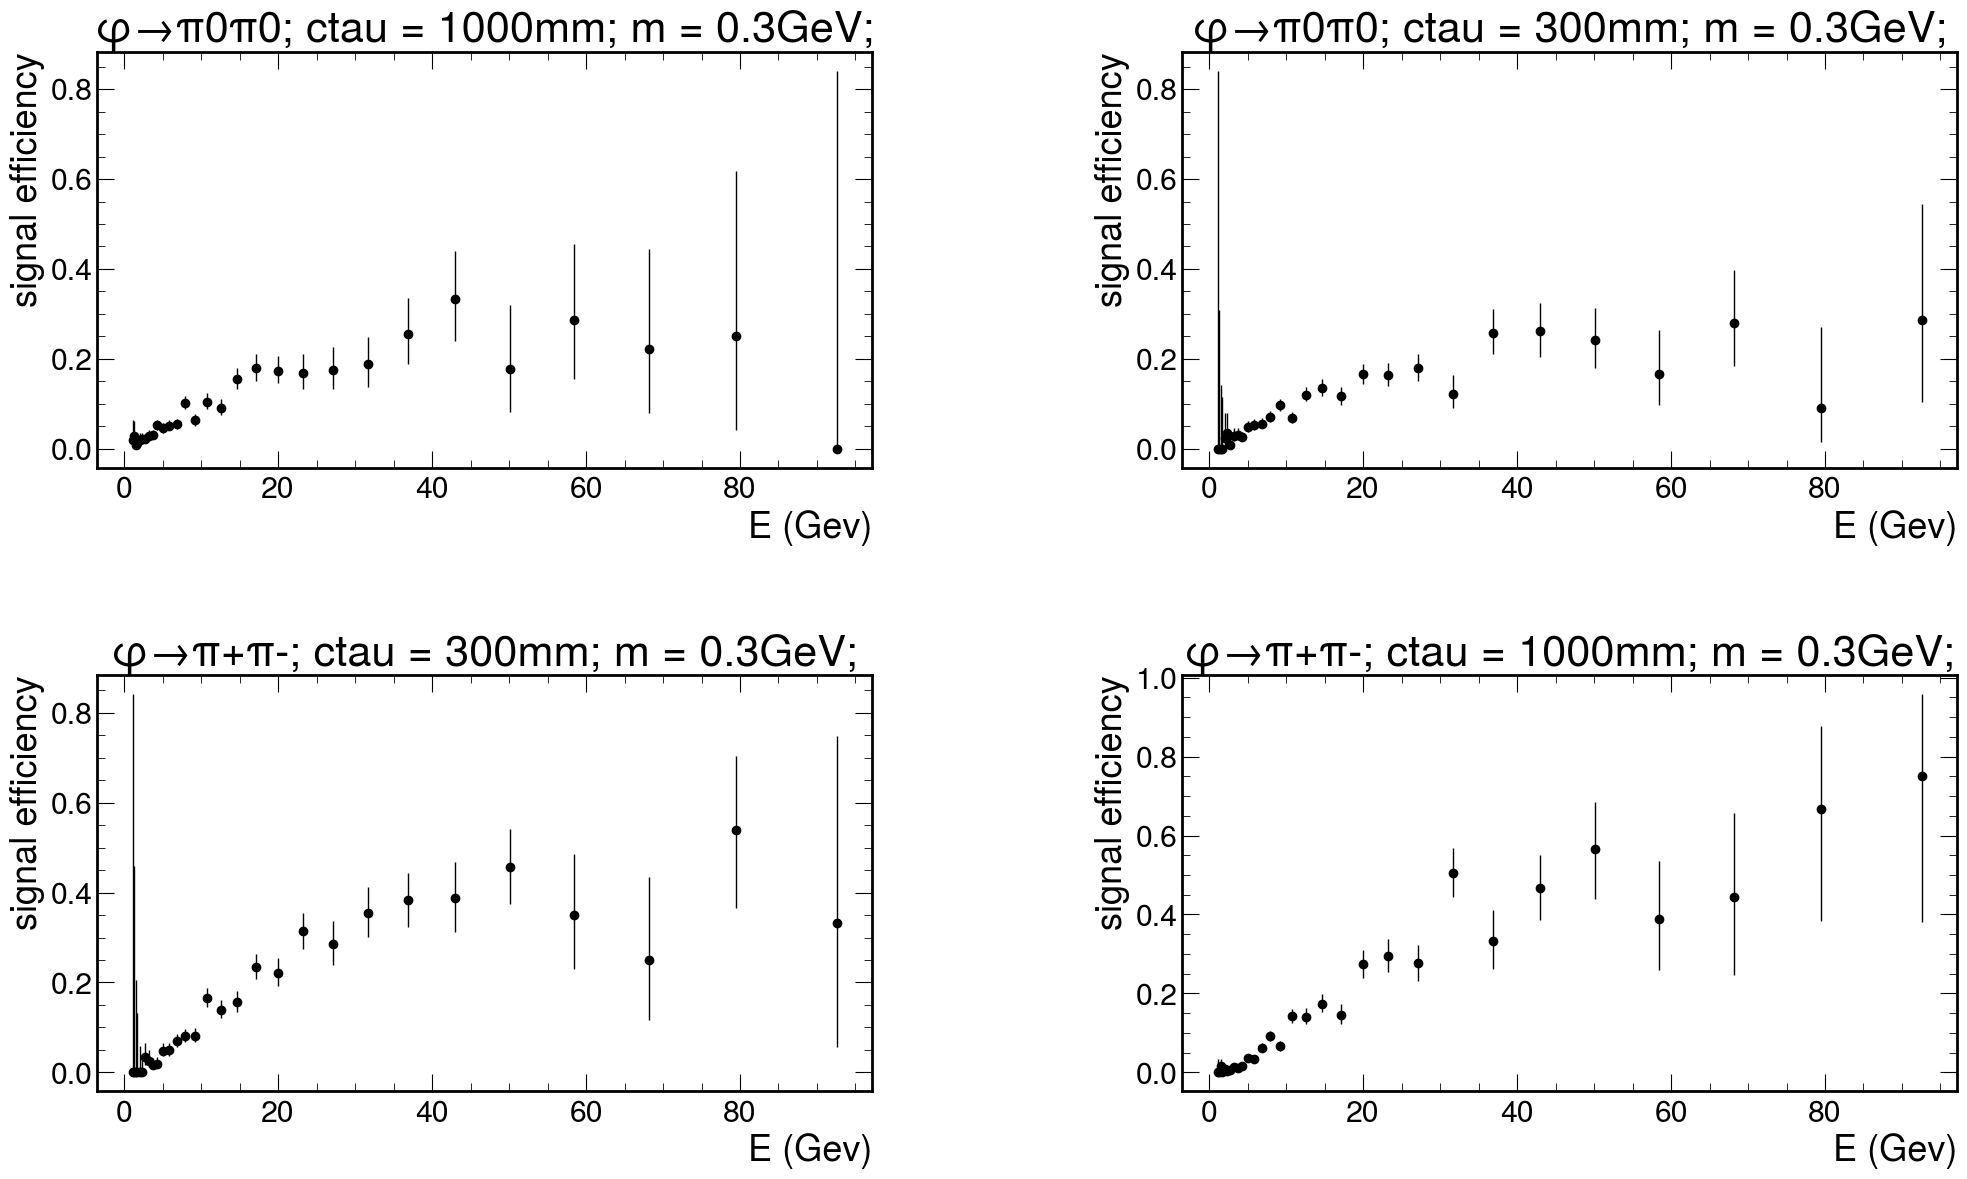

In [9]:
a = 1.5
fig, axes = plt.subplots(2,2, figsize = (a*16,a*9))

for ax, key in zip(axes.flatten(), datasets):
    ratio(out[key]['gLLP_e_matched with no_cut'], out[key]['gLLP_e with no_cut'], ax)
    ax.set_xlabel("E (Gev)")
    ax.set_ylabel("signal efficiency")
    s = ''
    if 'PiPlusPiMinus' in key:
        s+='φ→π+π-; '
    if 'Pi0Pi0' in key:
        s+='φ→π0π0; '

    if 'ctau1000' in key:
        s+='ctau = 1000mm; '
    if 'ctau300' in key:
        s+='ctau = 300mm; '
        
    if '0p3' in key:
        s+='m = 0.3GeV;'
    if '1p0' in key:
        s+='m = 1.0GeV;'
        
    ax.set_title(s)
        
fig.subplots_adjust(hspace=.5, wspace=.4)
        
plt.show()

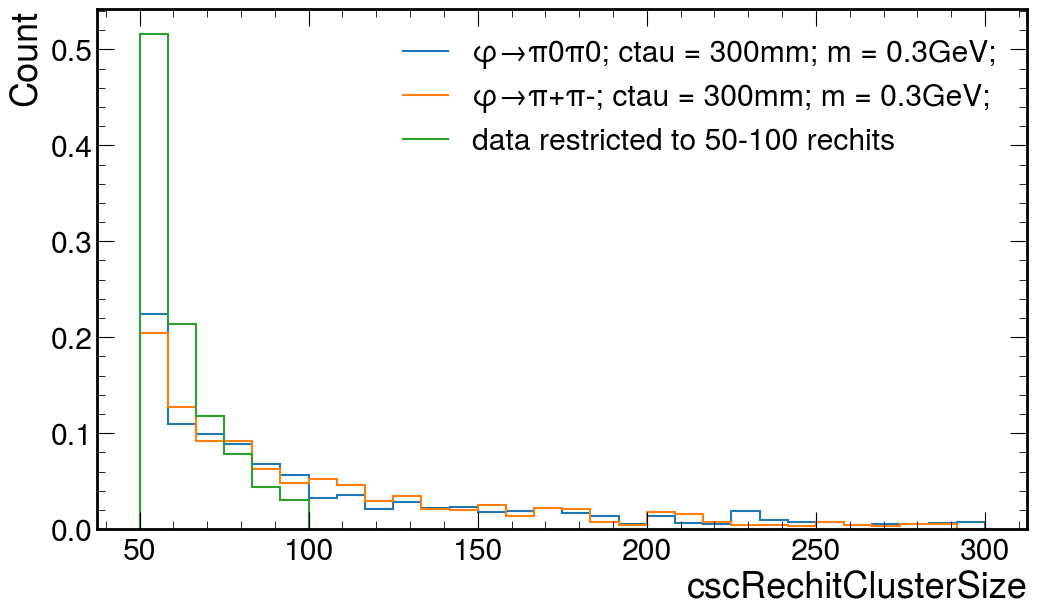

In [22]:
a = .75
fig, ax = plt.subplots(figsize = (a*16,a*9))

for key in [datasets[i] for i in [1,2,4]]:
    
    s = ''
    if 'PiPlusPiMinus' in key:
        s+='φ→π+π-; '
    if 'Pi0Pi0' in key:
        s+='φ→π0π0; '

    if 'ctau1000' in key:
        s+='ctau = 1000mm; '
    if 'ctau300' in key:
        s+='ctau = 300mm; '

    if '0p3' in key:
        s+='m = 0.3GeV;'
    if '1p0' in key:
        s+='m = 1.0GeV;'

    if 'background' in key:
        s+='data restricted to 50-100 rechits'
        temp = out[key][f'cscRechitClusterSize with in_csc'][:100j]/out[key][f'cscRechitClusterSize with in_csc'].sum()
    else:
        temp = out[key][f'cscRechitClusterSize with in_csc']/out[key][f'cscRechitClusterSize with in_csc'].sum()
    
    hep.histplot(temp, label = s, ax=ax)

plt.ylabel('Count')        
plt.legend()
plt.show()

In [24]:
datasets

['PhiToPi0Pi0_mPhi0p3_ctau1000',
 'PhiToPi0Pi0_mPhi0p3_ctau300',
 'PhiToPiPlusPiMinus_mPhi0p3_ctau300',
 'PhiToPiPlusPiMinus_mPhi0p3_ctau1000',
 'backgroundNew']

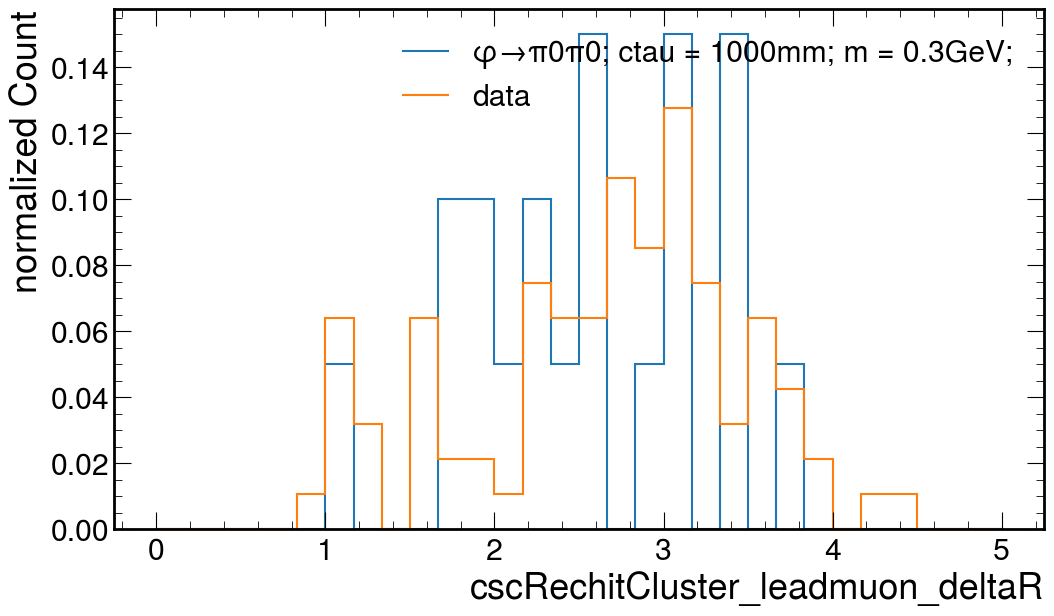

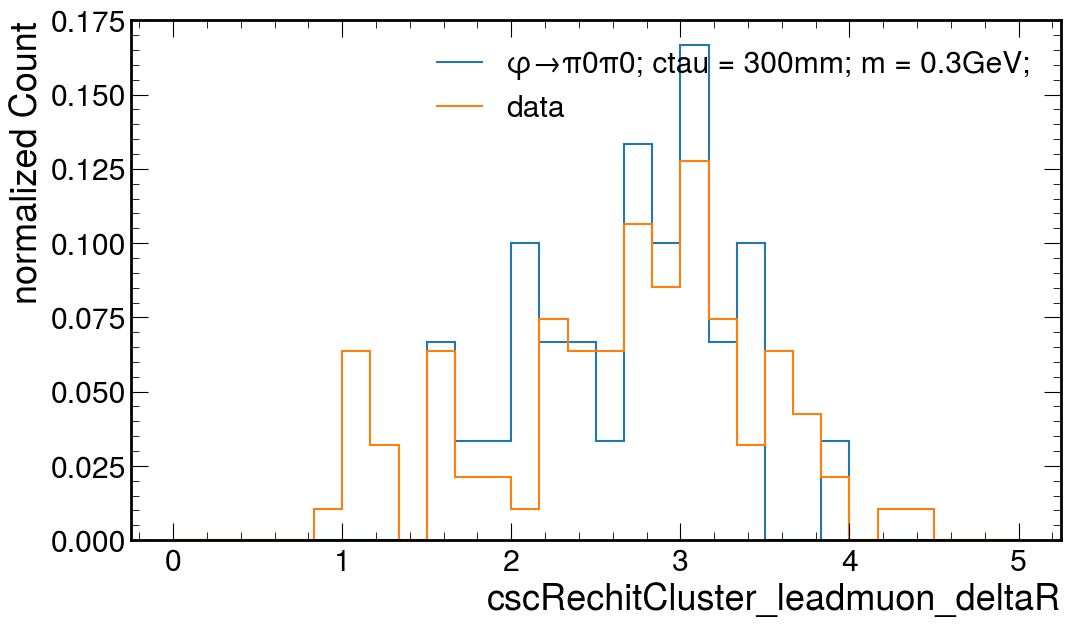

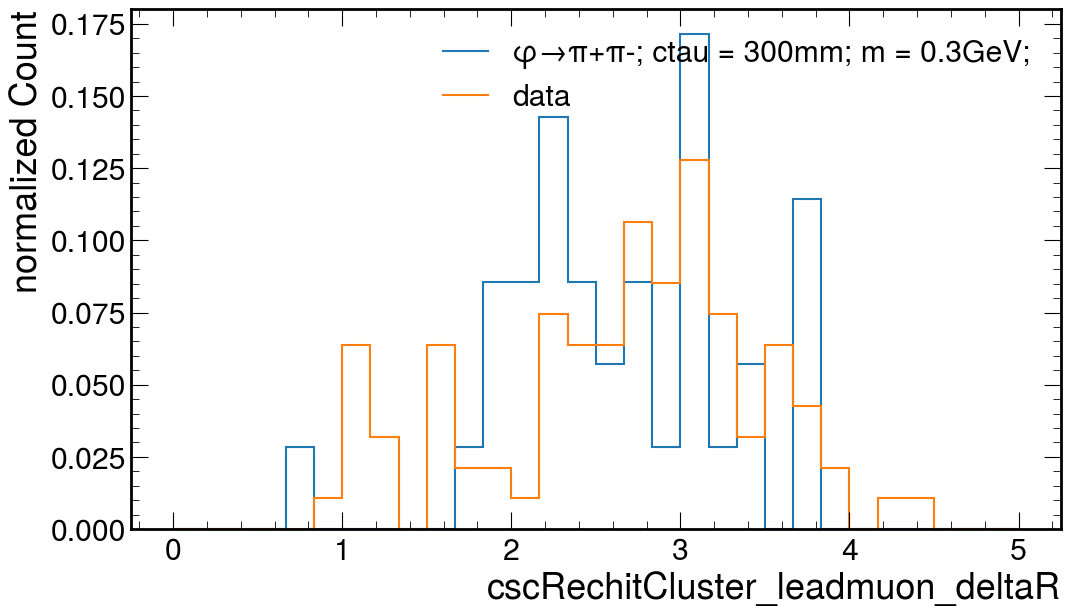

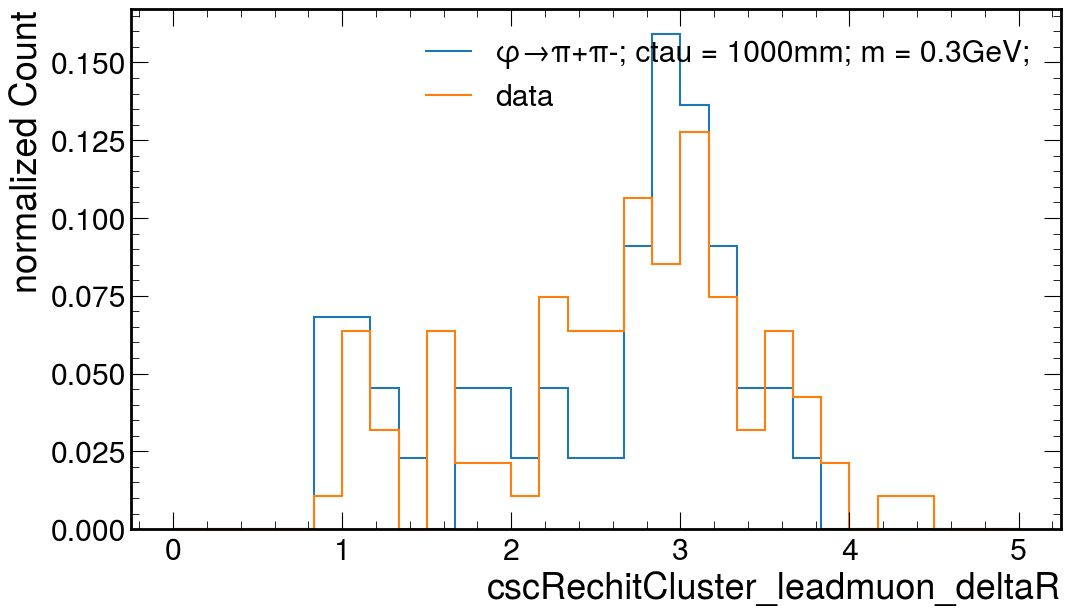

In [10]:
a = .75
for j in range(4):
    fig, ax = plt.subplots(figsize = (a*16,a*9))

    for key in [datasets[i] for i in [j,-1]]:

        s = ''
        if 'PiPlusPiMinus' in key:
            s+='φ→π+π-; '
        if 'Pi0Pi0' in key:
            s+='φ→π0π0; '

        if 'ctau1000' in key:
            s+='ctau = 1000mm; '
        if 'ctau300' in key:
            s+='ctau = 300mm; '

        if '0p3' in key:
            s+='m = 0.3GeV;'
        if '1p0' in key:
            s+='m = 1.0GeV;'

        if 'background' in key:
            s+='data'

        temp = out[key][f'cscRechitCluster_leadmuon_deltaR with cut_based_ID']/out[key][f'cscRechitCluster_leadmuon_deltaR with cut_based_ID'].sum()

        hep.histplot(temp, label = s, ax=ax)

    plt.ylabel('normalized Count')        
    plt.legend()
    plt.show()

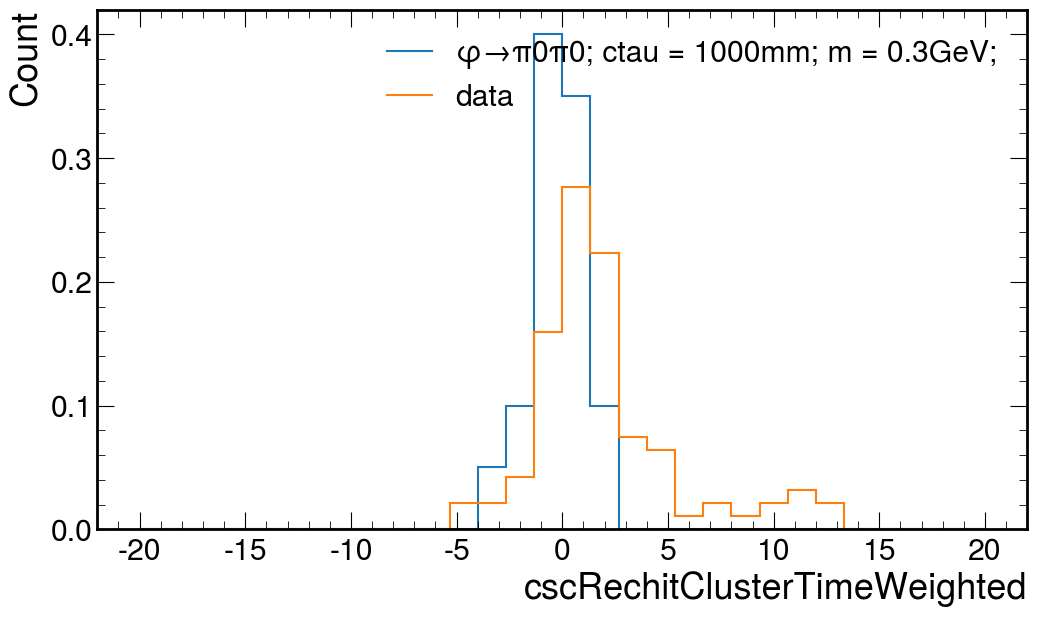

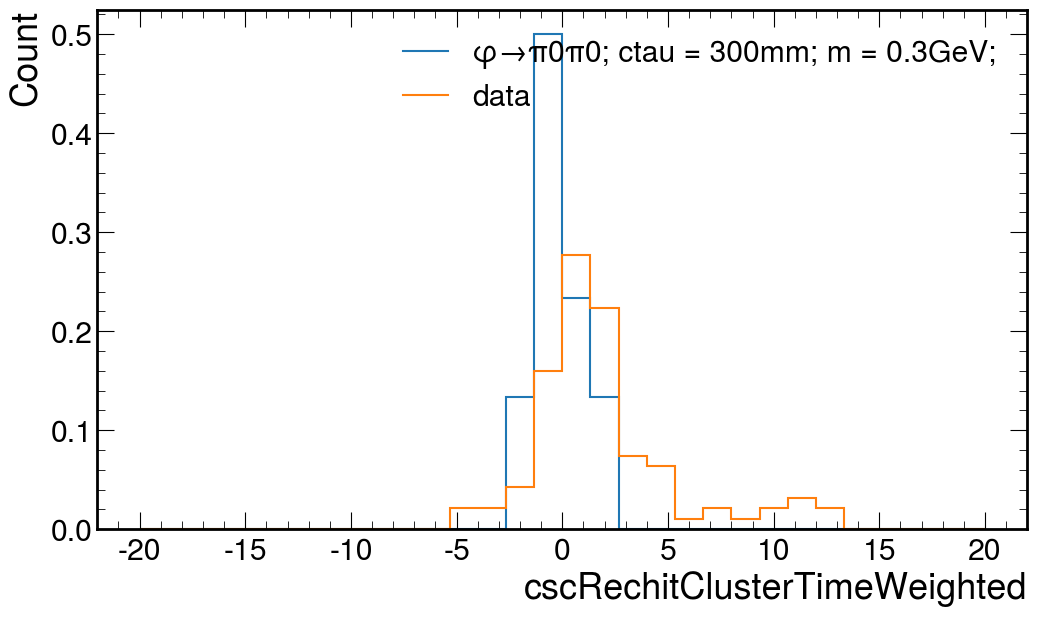

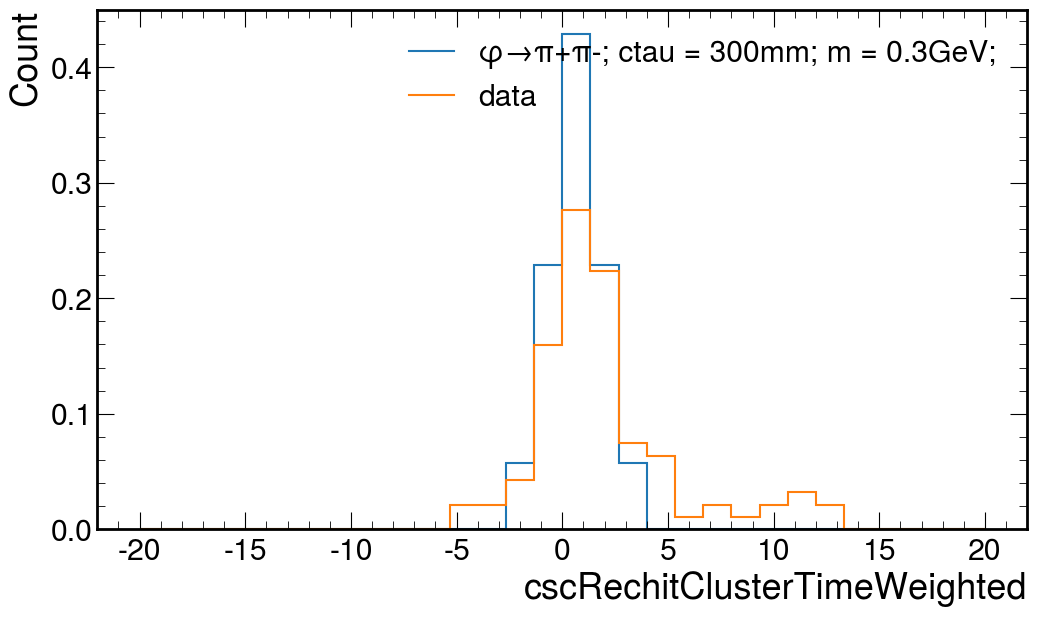

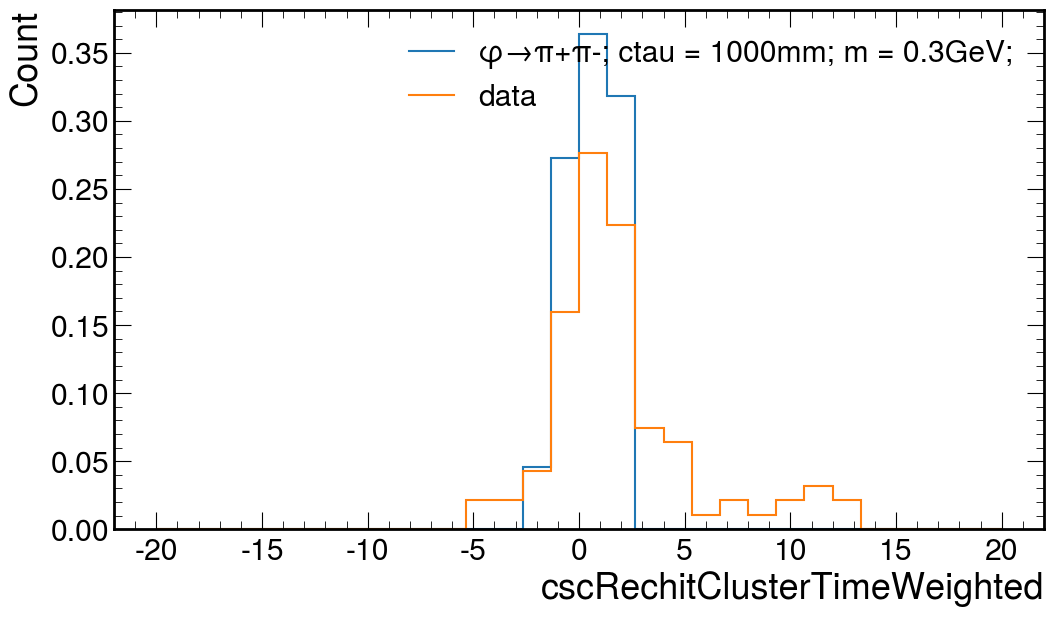

In [14]:
a = .75
for j in range(4):
    fig, ax = plt.subplots(figsize = (a*16,a*9))

    for key in [datasets[i] for i in [j,-1]]:

        s = ''
        if 'PiPlusPiMinus' in key:
            s+='φ→π+π-; '
        if 'Pi0Pi0' in key:
            s+='φ→π0π0; '

        if 'ctau1000' in key:
            s+='ctau = 1000mm; '
        if 'ctau300' in key:
            s+='ctau = 300mm; '

        if '0p3' in key:
            s+='m = 0.3GeV;'
        if '1p0' in key:
            s+='m = 1.0GeV;'

        if 'background' in key:
            s+='data'

        temp = out[key][f'cscRechitClusterTimeWeighted with cut_based_ID']/out[key][f'cscRechitClusterTimeWeighted with cut_based_ID'].sum()

        hep.histplot(temp, label = s, ax=ax)

    plt.ylabel('Count')        
    plt.legend()
    plt.show()

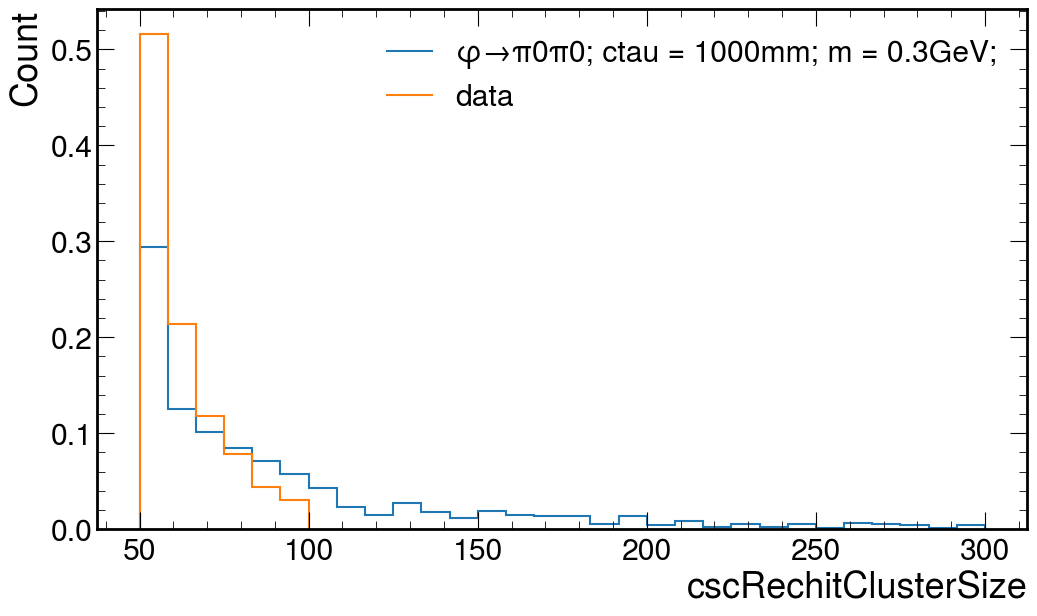

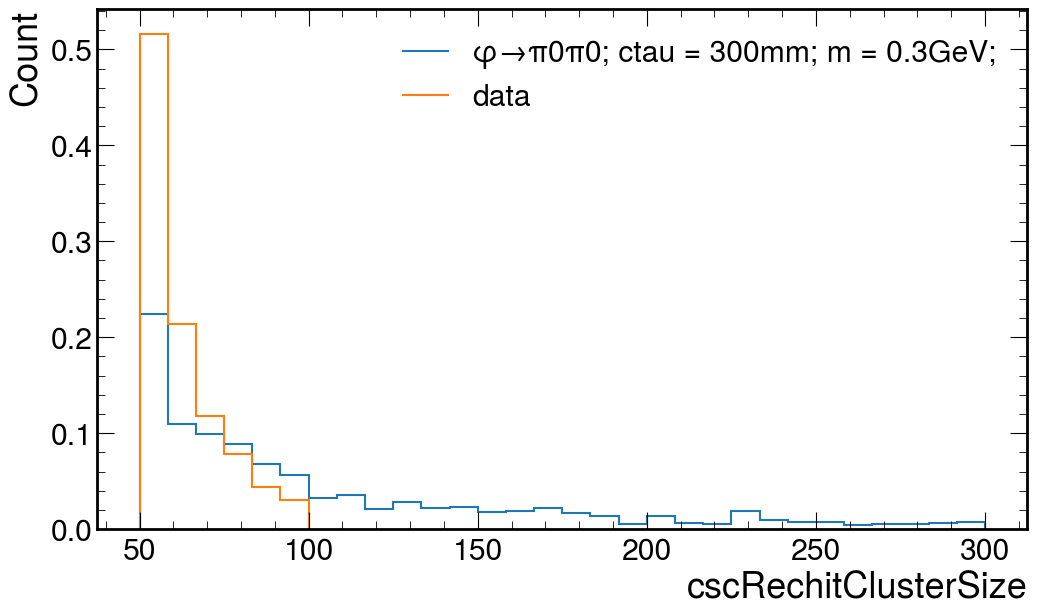

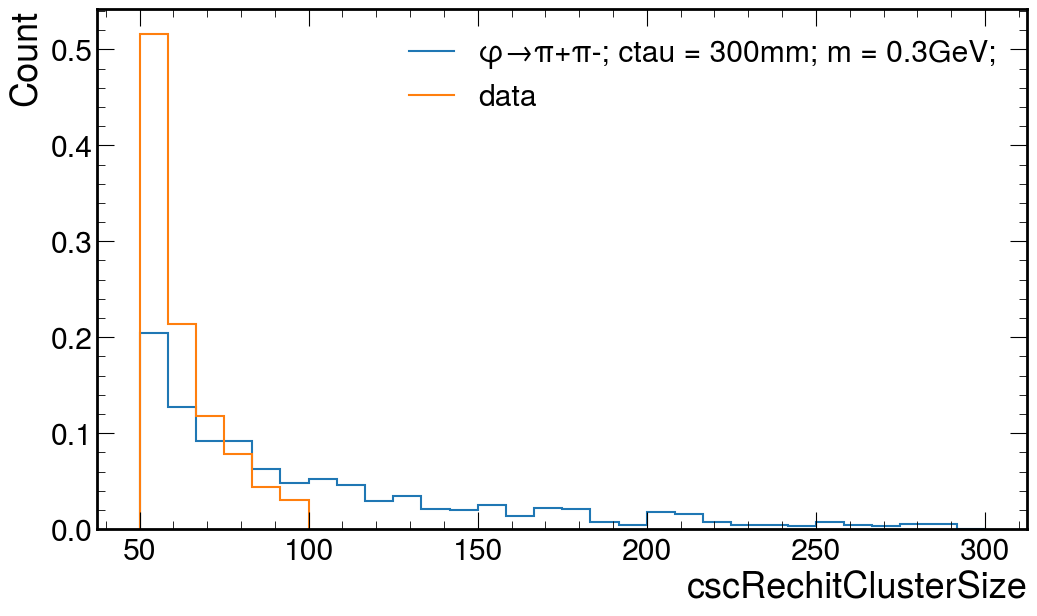

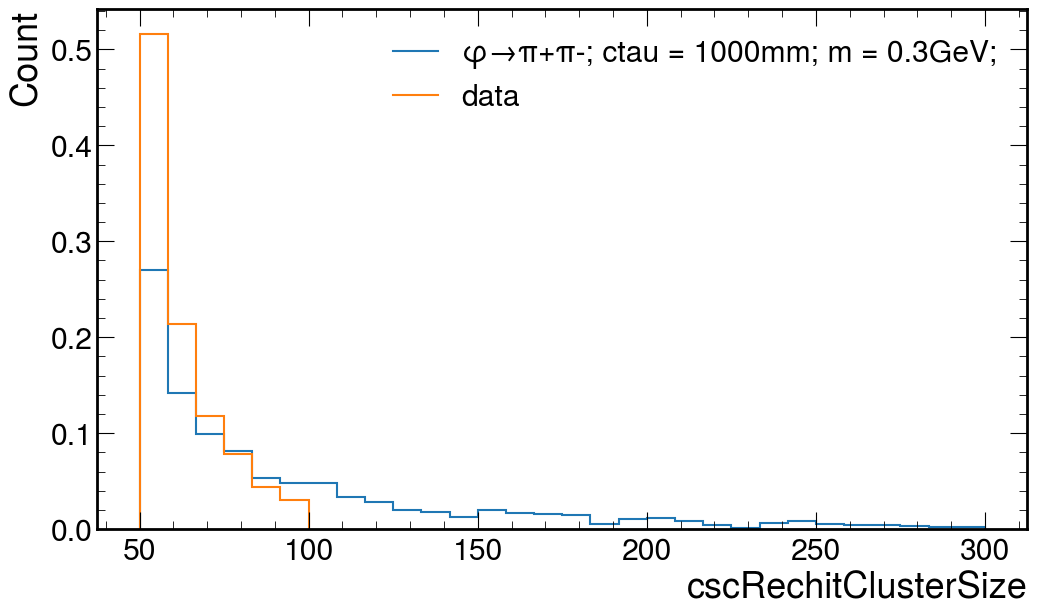

In [20]:
a = .75
for j in range(4):
    fig, ax = plt.subplots(figsize = (a*16,a*9))

    for key in [datasets[i] for i in [j,-1]]:

        s = ''
        if 'PiPlusPiMinus' in key:
            s+='φ→π+π-; '
        if 'Pi0Pi0' in key:
            s+='φ→π0π0; '

        if 'ctau1000' in key:
            s+='ctau = 1000mm; '
        if 'ctau300' in key:
            s+='ctau = 300mm; '

        if '0p3' in key:
            s+='m = 0.3GeV;'
        if '1p0' in key:
            s+='m = 1.0GeV;'

        if 'background' in key:
            s+='data'

        temp = out[key][f'cscRechitClusterSize with in_csc']/out[key][f'cscRechitClusterSize with in_csc'].sum()

        hep.histplot(temp, label = s, ax=ax)

    plt.ylabel('Count')        
    plt.legend()
    plt.show()